<a href="https://colab.research.google.com/github/fuat-arslan/Pytorch_Scratch/blob/main/CV/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Original paper is [DenseNet](https://arxiv.org/pdf/1608.06993v5.pdf)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from collections import OrderedDict

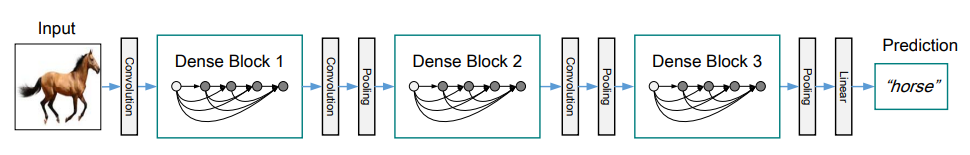

BottleNeck:
BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3)


In [2]:
class BottleNeck(nn.Module):
    def __init__(self,in_channels, growth_rate, expansion_dim, dropout_p):
        super().__init__()

        self.conv1_x = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels,
                      expansion_dim*growth_rate,
                      kernel_size=1,
                      stride=1,
                      bias=False)
        )

        self.conv2_x = nn.Sequential(
            nn.BatchNorm2d(expansion_dim*growth_rate),
            nn.ReLU(inplace=True),
            nn.Conv2d(expansion_dim*growth_rate,
                      growth_rate,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False)
        )

        self.p_dropout = dropout_p


    def forward(self, x):

        if isinstance(x, Tensor):
            prev_features = [x]
        else:
            prev_features = x

        merged_inputs = torch.cat(prev_features,1)
        next_features = self.conv1_x(merged_inputs)
        next_features = self.conv2_x(next_features)

        if self.p_dropout > 0:
            next_features = F.dropout(next_features, p=self.p_dropout,training = self.training)

        return next_features

In [17]:
class DenseBlock(nn.Module):
    def __init__(self, n_layers, in_channels, expansion_dim, growth_rate, p_dropout):
        super().__init__()

        # self.module_list = OrderedDict()
        self.module_list = nn.ModuleDict()

        for i in range(n_layers):

            #Since previous features are concatinated as channels for each layer
            bn = BottleNeck(in_channels + i*growth_rate, growth_rate, expansion_dim, p_dropout)

            self.module_list[f'layer{i+1}'] = bn

        # self.block = nn.Sequential(self.module_list)

    def forward(self, x):

        feature_list = [x]

        for name, layer in self.module_list.items():
            next_features = layer(feature_list)
            feature_list.append(next_features)
        return torch.cat(feature_list,1) #channel wise

Quick Test

In [18]:
B1 = DenseBlock(3,3,32,12,0.1)

In [19]:
img = torch.rand(4,3,224,224)

In [23]:
o1 = B1(img)

In [20]:
o1.shape #out_channels is  in_channels + n_layers*growth_rate = 3+3*12 = 39

torch.Size([4, 39, 224, 224])

As seen we preserve the shape and just adding channels. During the transition downsampling will be completed.

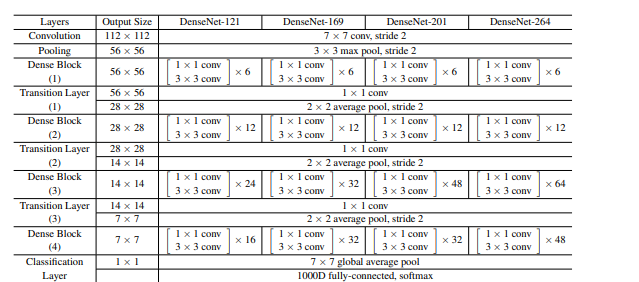

In [22]:
class Transition(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.norm = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2) #Half the shape

Quick Test

In [24]:
T = Transition(39,64)
T

Transition(
  (norm): BatchNorm2d(39, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv): Conv2d(39, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [26]:
o2 = T(o1)
o2.shape

torch.Size([4, 64, 112, 112])

Main Class

In [35]:
class DenseNet(nn.Module):
    def __init__(self, growth_rate, n_layers, in_channels, init_n_features ,expansion_dim, p_dropout, n_class):
        super().__init__()

        self.net = nn.Sequential(
            OrderedDict(
                [
                    ("conv0", nn.Conv2d(in_channels, init_n_features, kernel_size=7, stride=2, padding=3, bias=False)),
                    ("norm0", nn.BatchNorm2d(init_n_features)),
                    ("relu0", nn.ReLU(inplace=True)),
                    ("pool0", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                ]
            )

        )

        next_n_channel = init_n_features

        for i, n_layer in enumerate(n_layers):
            db = DenseBlock(n_layer, next_n_channel, expansion_dim, growth_rate, p_dropout)

            self.net.add_module(f'DenseBlock{i+1}', db)

            next_n_channel += n_layer * growth_rate

            #Add transition up until the last one
            if i != len(n_layers)-1:
                #According to paper out_channels halved at the transiiton
                transition_l = Transition(next_n_channel, next_n_channel//2 )
                self.net.add_module(f'Transition{i+1}', transition_l)
                next_n_channel = next_n_channel // 2

        #At the end
        self.net.add_module(f'batchnorm{len(n_layers)+1}', nn.BatchNorm2d(next_n_channel))

        self.fc = nn.Linear(next_n_channel, n_class)

        #weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):

        out = self.net(x)
        out = F.relu(out, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)

        return self.fc(out)





In [38]:
def densenet121(in_channels, expansion_dim, p_dorpout, n_class):
    return DenseNet(32,[6, 12, 24, 16], in_channels, 64, expansion_dim, p_dorpout, n_class)
def densenet161(in_channels, expansion_dim, p_dorpout, n_class):
    return DenseNet(48,[6, 12, 36, 24], in_channels, 96, expansion_dim, p_dorpout, n_class)
def densenet169(in_channels, expansion_dim, p_dorpout, n_class):
    return DenseNet(32,[6, 12, 32, 32], in_channels, 64, expansion_dim, p_dorpout, n_class)
def densenet201(in_channels, expansion_dim, p_dorpout, n_class):
    return DenseNet(32,[6, 12, 48, 32], in_channels, 64, expansion_dim, p_dorpout, n_class)

In [32]:
dd = densenet121(3,12,0,1000)

In [33]:
dd

DenseNet(
  (net): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (DenseBlock1): DenseBlock(
      (module_list): ModuleDict(
        (layer1): BottleNeck(
          (conv1_x): Sequential(
            (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (conv2_x): Sequential(
            (0): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(384, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
        )
        (layer2): BottleNeck(

In [40]:
#Quick Test
BATCH_SIZE = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = densenet201(3,12,0,1000).to(device)
y = net(torch.randn(BATCH_SIZE, 3, 224, 224)).to(device)
assert y.size() == torch.Size([BATCH_SIZE, 1000])
print(y.size())

torch.Size([4, 1000])


Passed the test